# TABLE OF CONTENT

[I. IMPORT NECESSARY LIBRARIES](#i-import-necessary-libraries)

[II. LOADING DATASET](#ii-loading-dataset)

[III. EXPLORATORY DATA ANALYSIS (EDA)](#iii-exploratory-data-analysis-eda)

  [1) Dataset overview](#1-dataset-overview)

  [2) Add `image_path` Column](#2-add-image_path-column)

  [3) ]

# I. IMPORT NECESSARY LIBRARIES

In [5]:
# Data manipulation libraries
import pandas as pd
import numpy as np
import random
import cv2
import os
from tqdm import tqdm
from collections import defaultdict
import imagehash

# Data visualization libraries
import matplotlib.pyplot as plt
import seaborn as sns

# Image Visualization
import matplotlib.image as mpimg
from PIL import Image

# Data preprocessing
from sklearn.model_selection import train_test_split

# Sklearn Library
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.metrics import (
    accuracy_score,
    classification_report,
    confusion_matrix,
    f1_score,
    precision_score,
    recall_score,
)

import pickle
from sklearn.metrics import (
    mean_absolute_error,
    mean_squared_error,
    r2_score,
    root_mean_squared_error
)

## Import Tensorflow for TensorFlow ≤ 2.12

In [ ]:
# # Deep learning libraries
# import tensorflow as tf
# from tensorflow.keras import layers, models
# from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
# from tensorflow.keras.models import Sequential
# from tensorflow.keras.layers import Dense, Flatten, Dropout
# from tensorflow.keras.optimizers import Adam
# from tensorflow.keras.preprocessing.image import ImageDataGenerator
# from tensorflow.keras.initializers import GlorotUniform
# from tensorflow.keras.layers import Conv2D, MaxPooling2D
# from tensorflow.keras.applications import NASNetMobile
# from tensorflow.keras.models import load_model, Model

## Using Keras for Keras 3.x with TensorFlow ≥ 2.13

In [6]:
# Deep learning libraries
import tensorflow as tf
from keras import Sequential, layers, models, Input
from keras.regularizers import l2
from keras.layers import Dense, Flatten, Dropout, Conv2D, MaxPooling2D, Dropout, BatchNormalization
from keras.optimizers import Adam
from keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from keras.src.legacy.preprocessing.image import ImageDataGenerator
from keras.initializers import GlorotUniform
from keras.applications import MobileNetV3Small, ResNet50V2, NASNetMobile
from keras.models import Model


# II. LOADING DATASET

In [9]:
df = pd.read_csv('./inputs/training_df.csv')
df

,image_id,label,variety,age,image_path
0,100330.jpg,bacterial_leaf_blight,ADT45,45,./inputs/train_images/bacterial_leaf_blight/10...
1,100365.jpg,bacterial_leaf_blight,ADT45,45,./inputs/train_images/bacterial_leaf_blight/10...
2,100382.jpg,bacterial_leaf_blight,ADT45,45,./inputs/train_images/bacterial_leaf_blight/10...
3,100632.jpg,bacterial_leaf_blight,ADT45,45,./inputs/train_images/bacterial_leaf_blight/10...
4,101918.jpg,bacterial_leaf_blight,ADT45,45,./inputs/train_images/bacterial_leaf_blight/10...
...,...,...,...,...,...
10402,107607.jpg,tungro,Zonal,55,./inputs/train_images/tungro/107607.jpg
10403,107811.jpg,tungro,Zonal,55,./inputs/train_images/tungro/107811.jpg
10404,108547.jpg,tungro,Zonal,55,./inputs/train_images/tungro/108547.jpg
10405,110245.jpg,tungro,Zonal,55,./inputs/train_images/tungro/110245.jpg


# IV. MODEL TRAINING

To ensure that the results are stable for multiple run time, we setup the seed for dataset

In [8]:
SEED = 42
random.seed(SEED)
np.random.seed(SEED)
tf.random.set_seed(SEED)

## 1) Helper Functions

In [11]:
def visualize_category_distribution(df, column_name):
    """
    Visualizes the distribution of categories from a specified column in the provided DataFrame.

    Parameters:
    - df: pandas DataFrame containing the column to visualize.
    - column_name: The column name whose distribution will be visualized.
    """
    # Calculate the frequency of each category in the specified column
    category_counts = df[column_name].value_counts()

    # Create a figure with two side-by-side plots
    fig, axes = plt.subplots(1, 2, figsize=(20, 10), facecolor="white")

    # Plot a pie chart in the first subplot
    color_palette = sns.color_palette("coolwarm")
    sns.set_palette(color_palette)
    axes[0].pie(
        category_counts, labels=category_counts.index, autopct="%1.1f%%", startangle=140
    )
    axes[0].set_title(f"{column_name} Distribution")

    # Plot a bar chart in the second subplot with the hue parameter
    sns.barplot(
        x=category_counts.index,
        y=category_counts.values,
        ax=axes[1],
        hue=category_counts.index,
        palette="coolwarm",
        legend=False,
    )
    axes[1].set_title(f"{column_name} Counts")

    # Adjust layout to ensure no overlapping of elements
    plt.tight_layout()

    # Display the plots
    plt.show()

In [12]:
def print_header(content, padding=10, width=None, tabs=False):
    """
    Prints a header wrapped inside a box.

    Parameters:
    - content: Text to display as header (automatically uppercase)
    - padding: Spaces on each side of the content inside the box
    - width: Optional fixed width for the entire box. If None, adjusts to content size.
    - tabs: If true, adds the spacing `\t`to center of the box
    """
    content = content.upper()
    inner_width = len(content) + (padding * 2)
    box_width = width if width and width > inner_width else inner_width

    top_bottom = "+" + "-" * (box_width + 2) + "+"
    padded_content = "| " + content.center(box_width) + " |"
    prefix = "\t" * 3 if tabs else ""

    print(f"{prefix}{top_bottom}")
    print(f"{prefix}{padded_content}")
    print(f"{prefix}{top_bottom}")

In [13]:
def plot_learning_curve(
    train_loss, val_loss, train_metric, val_metric, metric_name="Accuracy"
):

    plt.figure(figsize=(20, 10))

    plt.subplot(1, 2, 1)
    plt.plot(train_loss, "r--")
    plt.plot(val_loss, "b--")
    plt.xlabel("epochs")
    plt.ylabel("Loss")
    plt.legend(["train", "val"], loc="upper left")

    plt.subplot(1, 2, 2)
    plt.plot(train_metric, "r--")
    plt.plot(val_metric, "b--")
    plt.xlabel("epochs")
    plt.ylabel(metric_name)
    plt.legend(["train", "val"], loc="upper left")

    plt.show()

In [14]:
def save_model_and_history(
    model, history, model_name, model_dir="models", history_dir="models/history"
):
    os.makedirs(model_dir, exist_ok=True)
    os.makedirs(history_dir, exist_ok=True)

    # Save model
    model_path = os.path.join(model_dir, f"{model_name}.keras")
    model.save(model_path)

    # Save training history
    history_path = os.path.join(history_dir, f"{model_name}_history.pkl")
    with open(history_path, "wb") as f:
        pickle.dump(history, f)

    print(f"Model saved to {model_path}")
    print(f"Full history saved to {history_path}")

In [15]:
def load_lambda_histories(history_dir="models/history"):
    histories = {}

    for filename in os.listdir(history_dir):
        if filename.startswith("vgg_") and filename.endswith("lambda_history.pkl"):
            model_name = filename.replace("_history.pkl", "")
            with open(os.path.join(history_dir, filename), "rb") as f:
                histories[model_name] = pickle.load(f)

    return histories

In [16]:
def plot_regression_model_results(model_results, metric_name="MAE", title="Model Comparison", figsize=(12, 8)):
    """
    Plots training and validation regression metrics (like MAE, MSE) for multiple models side by side.

    Parameters:
    - model_results: Dictionary where keys are model names and values are tuples of (train_metric, val_metric)
    - metric_name: Name of the metric for y-axis label and title
    - title: Title for the plot
    - figsize: Figure size as (width, height)
    """
    import matplotlib.pyplot as plt
    import seaborn as sns
    import pandas as pd

    # Prepare data for plotting
    data = []
    for model_name, (train_metric, val_metric) in model_results.items():
        data.append({"Model": model_name, metric_name: train_metric, "Type": "Training"})
        data.append({"Model": model_name, metric_name: val_metric, "Type": "Validation"})

    plot_df = pd.DataFrame(data)

    plt.figure(figsize=figsize)
    ax = sns.barplot(x="Model", y=metric_name, hue="Type", data=plot_df, palette="coolwarm")

    # Add value labels on top of each bar
    for container in ax.containers:
        ax.bar_label(container, fmt="%.4f", padding=3)

    plt.title(title, fontsize=16)
    plt.ylabel(metric_name, fontsize=12)
    # For regression metrics like MAE/MSE, lower is better, so set y-limit accordingly
    min_metric = plot_df[metric_name].min()
    max_metric = plot_df[metric_name].max()
    margin = (max_metric - min_metric) * 0.1 if max_metric > min_metric else 1
    plt.ylim(max(0, min_metric - margin), max_metric + margin)

    plt.grid(axis="y", linestyle="--", alpha=0.7)
    plt.legend(title="", loc="upper right")
    plt.xticks(rotation=45 if len(model_results) > 3 else 0)

    plt.tight_layout()
    plt.show()


In [17]:
def evaluate_model_regression(model, generator, model_name):
    # Number of steps to cover the entire generator
    steps = int(np.ceil(generator.samples / generator.batch_size))

    # Collect true values and predictions
    y_true = []
    y_pred = []

    for i in range(steps):
        X_batch, y_batch = generator[i]
        preds = model.predict(X_batch).flatten()

        y_true.append(y_batch)
        y_pred.append(preds)

    y_true = np.concatenate(y_true).flatten()
    y_pred = np.concatenate(y_pred).flatten()

    # Calculate regression metrics
    mse = mean_squared_error(y_true, y_pred)
    mae = mean_absolute_error(y_true, y_pred)
    r2 = r2_score(y_true, y_pred)

    print(f"--- {model_name} Regression Evaluation ---")
    print(f"Mean Squared Error (MSE): {mse:.4f}")
    print(f"Mean Absolute Error (MAE): {mae:.4f}")
    print(f"R² Score: {r2:.4f}\n")


## 2) Task 3: Predict Age's Plant

**Justification for using Regression in Task 3:**
- Continuous Output: Age is a continuous variable, not discreates classes so regression can pre-dict exact values without losing precision
- Avoid Information Loss: Regression can predict directly the exact value of age while Classifi-cation requires binning ages into categories which can result in reducing accuracy and infor-mation.
- Suitable Loss Functions: Regression uses losses such as MAE and MSE that directly measure prediction errors on continuous targets.


### 2.1) Data Preparation

In [18]:
# Define random_state
random_state = 42

train_df, val_df = train_test_split(df, test_size=0.2, random_state=random_state)

print_header("Train Dataset shape")
print("Number of Rows: ", train_df.shape[0])
print("Number of Columns: ", train_df.shape[1])

print_header("Validation Dataset Shape")
print("Number of Rows: ", val_df.shape[0])
print("Number of Columns: ", val_df.shape[1])

+-----------------------------------------+
|           TRAIN DATASET SHAPE           |
+-----------------------------------------+
Number of Rows:  8325
Number of Columns:  5
+----------------------------------------------+
|           VALIDATION DATASET SHAPE           |
+----------------------------------------------+
Number of Rows:  2082
Number of Columns:  5


We can observe that the age distribution is quite imbalanced, with`70` classes account for 29.7% of the dataset, while minority classes such as `62` and `82` accounts for less than 0.5% of the dataset. However, in this task we will consider it as regression problem based on the justification above so the imbalance is not a problem.

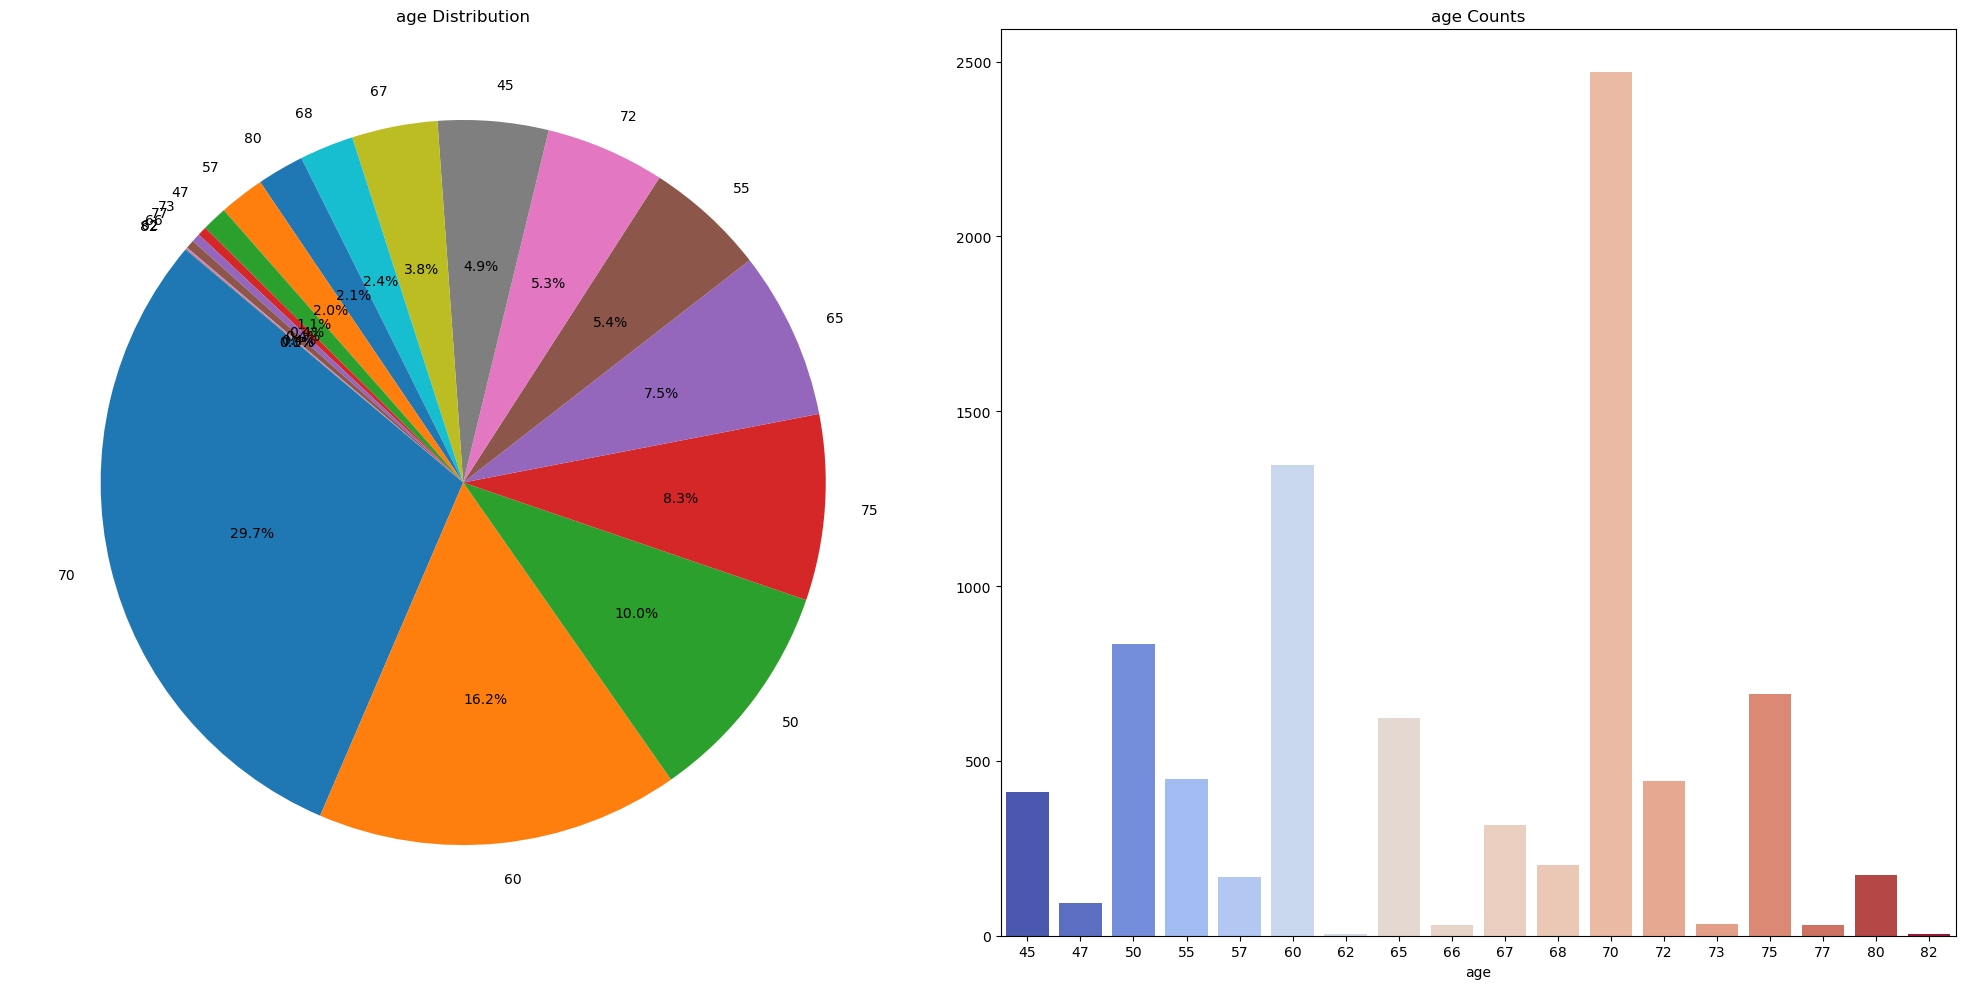

In [13]:
visualize_category_distribution(train_df, "age")

In [14]:
train_df["age"].value_counts()

age
70    2469
60    1346
50     835
75     690
65     622
55     449
72     442
45     410
67     318
68     201
80     174
57     168
47      94
73      34
77      32
66      32
62       5
82       4
Name: count, dtype: int64

**Global Variables**

We set batch size to 32 and the Input_DIM as 64,64,3 for faster testing, in the final code we agreed to set the code to 128,128,3 for the image clarity

In [20]:
BATCH_SIZE = 32
INPUT_DIM = (64,64,3)

**Image Generator**

Using class_mode = 'raw' to return the age as a continuous value

In [ ]:
train_datagen = ImageDataGenerator(rescale=1./255, data_format='channels_last')
val_datagen = ImageDataGenerator(rescale=1./255, data_format='channels_last')

train_generator_age = train_datagen.flow_from_dataframe(
    dataframe=train_df,
    directory="",
    x_col='image_path',
    y_col='age',
    target_size= (64,64),
    batch_size= BATCH_SIZE,
    class_mode='raw',
    shuffle=True,
    seed=42
)

val_generator_age = val_datagen.flow_from_dataframe(
    dataframe=val_df,
    directory="",
    x_col='image_path',
    y_col='age',
    target_size=(64, 64),
    batch_size=BATCH_SIZE,
    class_mode='raw',
    shuffle=False,
    seed=42
)

Found 8325 validated image filenames.
Found 2082 validated image filenames.


### 2.2) Baseline Model

**Summary Table**

| Model        | Parameters | Strengths                        | Typical Applications              |
|--------------|------------|---------------------------------|---------------------------------|
| MobileNetV3  | ~1.5M–5.4M | Lightweight, fast, efficient     | Mobile/edge devices, real-time  |
| ResNet50V2   | ~25M       | Deep, accurate, stable training  | General vision tasks, transfer learning |
| NASNetMobile | ~5.3M      | NAS-designed, efficient modular  | Mobile vision tasks, custom solutions |


**MobileNetV3Small**

1. **Optimized for Resource-Constrained Environments**  
   Its small model size and low computational cost enable fast inference, ideal for real-time applications in agricultural image analysis where hardware resources may be limited.

2. **Good Balance of Speed and Accuracy**  
   MobileNetV3’s architecture, especially the “Small” variant, strikes a balance that supports rapid training and deployment without significant loss in performance on fine-grained tasks like paddy variety classification.

3. **Flexible Transfer Learning**  
   MobileNetV3 supports transfer learning with pretrained weights, accelerating convergence and helping mitigate issues related to imbalanced datasets by leveraging rich feature representations.

In [32]:
MobileNetV3Small_base = MobileNetV3Small(
        input_shape= INPUT_DIM,
        include_top=False,
        weights=None,  # Random weights
        pooling='avg'  # Global average pooling
)

x = MobileNetV3Small_base.output
output  = Dense(1, activation='linear')(x)
MobileNetV3Small_model = Model(inputs=MobileNetV3Small_base.input, outputs=output)

MobileNetV3Small_model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 64, 64, 3) │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ rescaling           │ (None, 64, 64, 3) │          0 │ input_layer[0][0] │
│ (Rescaling)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv (Conv2D)       │ (None, 32, 32,    │        432 │ rescaling[0][0]   │
│                     │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv_bn             │ (None, 32, 32,    │         64 │ conv[0][0]        │
│ (BatchNormalizatio… │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation          │ (None, 32, 32,    │          0 │ conv_bn[0][0]     │
│ (Activation)        │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 33, 33,    │          0 │ activation[0][0]  │
│ (ZeroPadding2D)     │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 16, 16,    │        144 │ expanded_conv_de… │
│ (DepthwiseConv2D)   │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 16, 16,    │         64 │ expanded_conv_de… │
│ (BatchNormalizatio… │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ re_lu (ReLU)        │ (None, 16, 16,    │          0 │ expanded_conv_de… │
│                     │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_sque… │ (None, 1, 1, 16)  │          0 │ re_lu[0][0]       │
│ (GlobalAveragePool… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_sque… │ (None, 1, 1, 8)   │        136 │ expanded_conv_sq… │
│ (Conv2D)            │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_sque… │ (None, 1, 1, 8)   │          0 │ expanded_conv_sq… │
│ (ReLU)              │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_sque… │ (None, 1, 1, 16)  │        144 │ expanded_conv_sq… │
│ (Conv2D)            │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add (Add)           │ (None, 1, 1, 16)  │          0 │ expanded_conv_sq… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ re_lu_1 (ReLU)      │ (None, 1, 1, 16)  │          0 │ add[0][0]         │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ multiply (Multiply) │ (None, 1, 1, 16)  │          0 │ re_lu_1[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_sque… │ (None, 16, 16,    │          0 │ re_lu[0][0],      │
│ (Multiply)          │ 16)               │            │ multiply[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, 16, 16,    │        256 │ expanded_conv_sq

 Total params: 939,697 (3.58 MB)

 Trainable params: 927,585 (3.54 MB)

 Non-trainable params: 12,112 (47.31 KB)

In [33]:
MobileNetV3Small_model.compile(optimizer='adam',loss="mse", metrics=["mae"])

# Train the EfficientNetB0 model
MobileNetV3Small_history = MobileNetV3Small_model.fit(
    train_generator_age, validation_data=val_generator_age,
    epochs=20, verbose=1,
)

c:\Anaconda\envs\tf219_env\lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/20
261/261 ━━━━━━━━━━━━━━━━━━━━ 183s 638ms/step - loss: 3116.4983 - mae: 54.1407 - val_loss: 2076.2803 - val_mae: 44.6682
Epoch 2/20
261/261 ━━━━━━━━━━━━━━━━━━━━ 54s 208ms/step - loss: 107.7076 - mae: 8.8874 - val_loss: 1596.8016 - val_mae: 38.9329
Epoch 3/20
261/261 ━━━━━━━━━━━━━━━━━━━━ 57s 220ms/step - loss: 65.9277 - mae: 6.7013 - val_loss: 1560.2739 - val_mae: 38.4609
Epoch 4/20
261/261 ━━━━━━━━━━━━━━━━━━━━ 58s 221ms/step - loss: 59.5367 - mae: 6.1976 - val_loss: 1511.7345 - val_mae: 37.8246
Epoch 5/20
261/261 ━━━━━━━━━━━━━━━━━━━━ 59s 226ms/step - loss: 52.8814 - mae: 5.7336 - val_loss: 1468.7299 - val_mae: 37.2518
Epoch 6/20
261/261 ━━━━━━━━━━━━━━━━━━━━ 55s 211ms/step - loss: 44.4746 - mae: 5.1467 - val_loss: 1411.4878 - val_mae: 36.4754
Epoch 7/20
261/261 ━━━━━━━━━━━━━━━━━━━━ 55s 211ms/step - loss: 39.1060 - mae: 4.7554 - val_loss: 1366.6818 - val_mae: 35.8560
Epoch 8/20
261/261 ━━━━━━━━━━━━━━━━━━━━ 69s 263ms/step - loss: 31.2516 - mae: 4.1446 - val_loss: 1331.4474 - val_

In [34]:
save_model_and_history(
    MobileNetV3Small_model,
    MobileNetV3Small_history,
    model_name="mobilenetv3small_model",
    model_dir="models",
    history_dir="models/history",
)

Model saved to models\mobilenetv3small_model.keras
Full history saved to models/history\mobilenetv3small_model_history.pkl


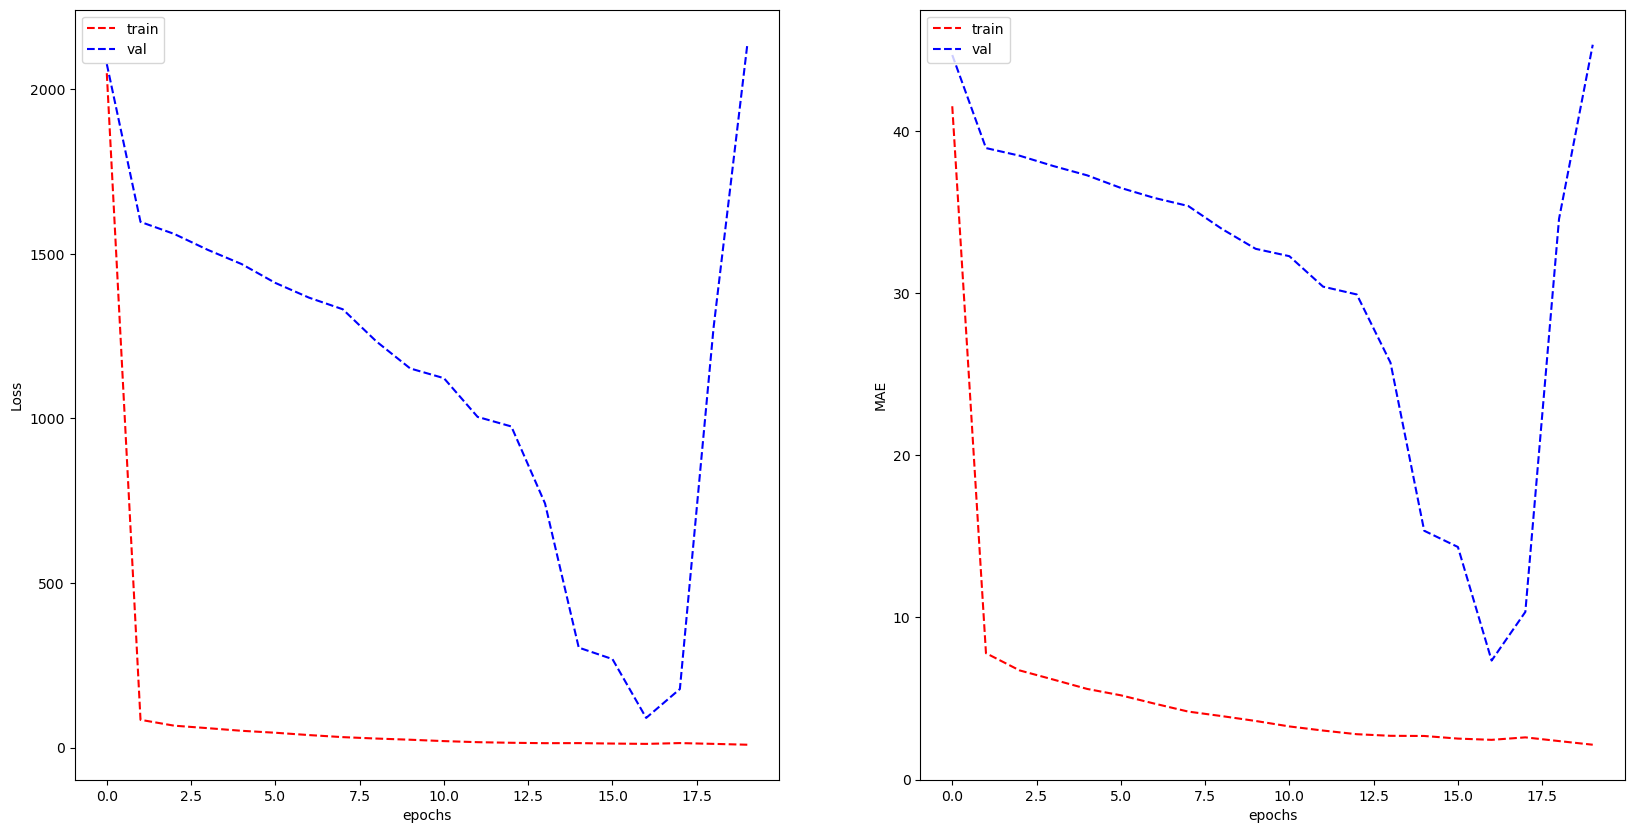

In [37]:
plot_learning_curve(
    MobileNetV3Small_history.history["loss"],
    MobileNetV3Small_history.history["val_loss"],
    MobileNetV3Small_history.history["mae"],
    MobileNetV3Small_history.history["val_mae"],
    metric_name="MAE",
)

**ResNet50V2**

1. **Improved Residual Learning**  
   ResNet50V2 introduces pre-activation residual blocks that improve gradient flow, making it easier to train deeper networks capable of capturing intricate visual patterns in paddy images.

2. **Enhanced Feature Extraction**  
   Its deep architecture efficiently learns hierarchical features, enabling precise discrimination of subtle differences between paddy disease types and varieties.

3. **Strong Regularization and Generalization**  
   Pre-activation and batch normalization layers help reduce overfitting, which is crucial when handling imbalanced classes or limited data samples in agricultural datasets.

4. **Robustness with Data Augmentation**  
   ResNet50V2’s design works well with augmented data, enhancing model robustness and helping maintain accuracy across varying field conditions.

In [38]:
ResNet50V2_base = ResNet50V2(
    input_shape=INPUT_DIM,
    include_top=False,
    weights=None,  # random initialization
    pooling='avg'  # global average pooling
)

x = ResNet50V2_base.output
output = Dense(1, activation='linear')(x)

ResNet50V2_model = Model(inputs=ResNet50V2_base.input, outputs=output)

ResNet50V2_model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1       │ (None, 64, 64, 3) │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_pad           │ (None, 70, 70, 3) │          0 │ input_layer_1[0]… │
│ (ZeroPadding2D)     │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_conv (Conv2D) │ (None, 32, 32,    │      9,472 │ conv1_pad[0][0]   │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pad           │ (None, 34, 34,    │          0 │ conv1_conv[0][0]  │
│ (ZeroPadding2D)     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pool          │ (None, 16, 16,    │          0 │ pool1_pad[0][0]   │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_preac… │ (None, 16, 16,    │        256 │ pool1_pool[0][0]  │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_preac… │ (None, 16, 16,    │          0 │ conv2_block1_pre… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_conv │ (None, 16, 16,    │      4,096 │ conv2_block1_pre… │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_bn   │ (None, 16, 16,    │        256 │ conv2_block1_1_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_relu │ (None, 16, 16,    │          0 │ conv2_block1_1_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_pad  │ (None, 18, 18,    │          0 │ conv2_block1_1_r… │
│ (ZeroPadding2D)     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_conv │ (None, 16, 16,    │     36,864 │ conv2_block1_2_p… │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_bn   │ (None, 16, 16,    │        256 │ conv2_block1_2_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_relu │ (None, 16, 16,    │          0 │ conv2_block1_2_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_conv │ (None, 16, 16,    │     16,640 │ conv2_block1_pre… │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_conv │ (None, 16, 16,    │     16,640 │ conv2_block1_2_r… │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_out    │ (None, 16, 16,    │          0 │ conv2_block1_0_c

 Total params: 23,566,849 (89.90 MB)

 Trainable params: 23,521,409 (89.73 MB)

 Non-trainable params: 45,440 (177.50 KB)

In [39]:
# Compile the ResNet50V2 model
ResNet50V2_model.compile(optimizer='adam', loss="mse", metrics=["mae"])

# Train the ResNet50V2 model
ResNet50V2_history = ResNet50V2_model.fit(
    train_generator_age, validation_data=val_generator_age,
    epochs=20, verbose=1,
)

Epoch 1/20
261/261 ━━━━━━━━━━━━━━━━━━━━ 217s 750ms/step - loss: 1061.5570 - mae: 25.3269 - val_loss: 153.6148 - val_mae: 10.6085
Epoch 2/20
261/261 ━━━━━━━━━━━━━━━━━━━━ 195s 748ms/step - loss: 53.3316 - mae: 5.7674 - val_loss: 61.2155 - val_mae: 5.9026
Epoch 3/20
261/261 ━━━━━━━━━━━━━━━━━━━━ 199s 761ms/step - loss: 38.6242 - mae: 4.7189 - val_loss: 64.9736 - val_mae: 6.5102
Epoch 4/20
261/261 ━━━━━━━━━━━━━━━━━━━━ 198s 757ms/step - loss: 29.3058 - mae: 4.0532 - val_loss: 44.0469 - val_mae: 5.2783
Epoch 5/20
261/261 ━━━━━━━━━━━━━━━━━━━━ 199s 763ms/step - loss: 21.7786 - mae: 3.4566 - val_loss: 61.9952 - val_mae: 6.4869
Epoch 6/20
261/261 ━━━━━━━━━━━━━━━━━━━━ 199s 761ms/step - loss: 20.3466 - mae: 3.2763 - val_loss: 75.3656 - val_mae: 6.1333
Epoch 7/20
261/261 ━━━━━━━━━━━━━━━━━━━━ 200s 764ms/step - loss: 15.8977 - mae: 2.8905 - val_loss: 44.3718 - val_mae: 4.6875
Epoch 8/20
261/261 ━━━━━━━━━━━━━━━━━━━━ 204s 783ms/step - loss: 9.7290 - mae: 2.2709 - val_loss: 40.6286 - val_mae: 4.5845
Epoc

In [40]:
# Save model and history
save_model_and_history(
    ResNet50V2_model,
    ResNet50V2_history,
    model_name="resnet50v2_model",
    model_dir="models",
    history_dir="models/history",
)


Model saved to models\resnet50v2_model.keras
Full history saved to models/history\resnet50v2_model_history.pkl


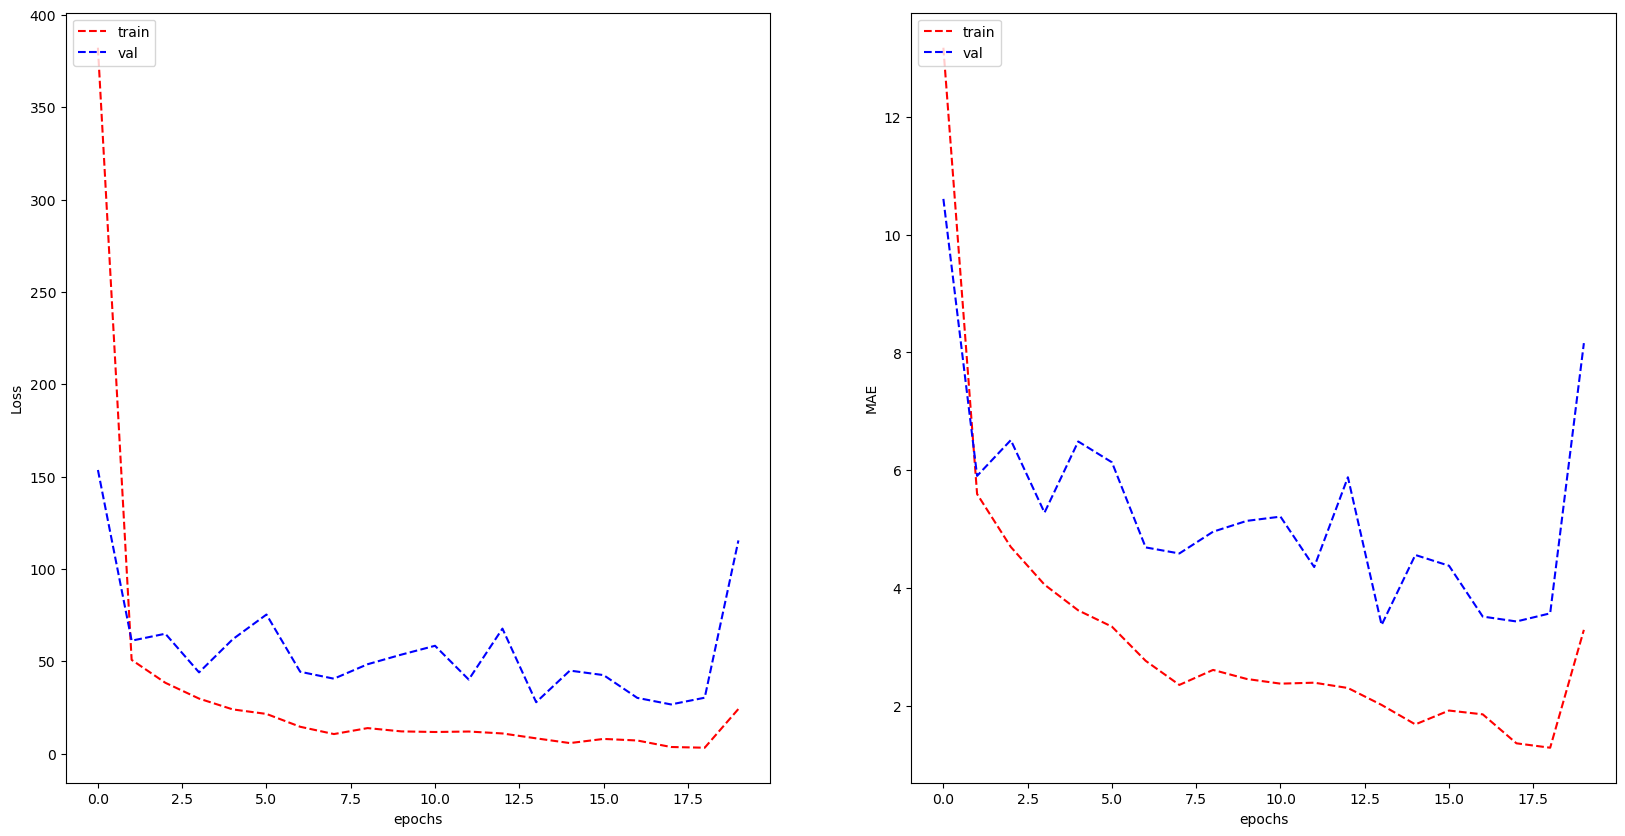

In [41]:
plot_learning_curve(
    ResNet50V2_history.history["loss"],
    ResNet50V2_history.history["val_loss"],
    ResNet50V2_history.history["mae"],
    ResNet50V2_history.history["val_mae"],
    metric_name="MAE",
)

**NasNetMobile**

1. **Neural Architecture Search Optimized**  
   NASNetMobile leverages automated neural architecture search to design efficient, modular building blocks, achieving a good balance between accuracy and computational cost.

2. **Flexible and Modular Design**  
   Its cell-based architecture allows customization and easy scaling to fit specific agricultural imaging tasks without excessive computational overhead.

4. **Good Transfer Learning Performance**  
   Pretrained NASNetMobile models provide strong baseline features, accelerating training and improving performance, especially when data availability is limited or imbalanced.

In [42]:
# Build the NASNetMobile base model
NASNetMobile_base = NASNetMobile(
    input_shape=INPUT_DIM,
    include_top=False,
    weights=None,  
    pooling='avg'  
)

x = NASNetMobile_base.output
output = Dense(1, activation='linear')(x)

NASNetMobile_model = Model(inputs=NASNetMobile_base.input, outputs=output)

NASNetMobile_model.summary()

Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_2       │ (None, 64, 64, 3) │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_conv1 (Conv2D) │ (None, 31, 31,    │        864 │ input_layer_2[0]… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_bn1            │ (None, 31, 31,    │        128 │ stem_conv1[0][0]  │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_18       │ (None, 31, 31,    │          0 │ stem_bn1[0][0]    │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ reduction_conv_1_s… │ (None, 31, 31,    │        352 │ activation_18[0]… │
│ (Conv2D)            │ 11)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ reduction_bn_1_ste… │ (None, 31, 31,    │         44 │ reduction_conv_1… │
│ (BatchNormalizatio… │ 11)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_19       │ (None, 31, 31,    │          0 │ reduction_bn_1_s… │
│ (Activation)        │ 11)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_21       │ (None, 31, 31,    │          0 │ stem_bn1[0][0]    │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ separable_conv_1_p… │ (None, 35, 35,    │          0 │ activation_19[0]… │
│ (ZeroPadding2D)     │ 11)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ separable_conv_1_p… │ (None, 37, 37,    │          0 │ activation_21[0]… │
│ (ZeroPadding2D)     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ separable_conv_1_r… │ (None, 16, 16,    │        396 │ separable_conv_1… │
│ (SeparableConv2D)   │ 11)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ separable_conv_1_r… │ (None, 16, 16,    │      1,920 │ separable_conv_1… │
│ (SeparableConv2D)   │ 11)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ separable_conv_1_b… │ (None, 16, 16,    │         44 │ separable_conv_1… │
│ (BatchNormalizatio… │ 11)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ separable_conv_1_b… │ (None, 16, 16,    │         44 │ separable_conv_1… │
│ (BatchNormalizatio… │ 11)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_20       │ (None, 16, 16,    │          0 │ separable_conv_1… │
│ (Activation)        │ 11)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_22       │ (None, 16, 16,    │          0 │ separable_conv_1… │
│ (Activation)        │ 11)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ separable_conv_2_r… │ (None, 16, 16,    │        396 │ activation_20[0]

 Total params: 4,270,773 (16.29 MB)

 Trainable params: 4,234,035 (16.15 MB)

 Non-trainable params: 36,738 (143.51 KB)

In [43]:
# Compile the NASNetMobile model
NASNetMobile_model.compile(optimizer='adam', loss="mse", metrics=["mae"])

# Train the NASNetMobile model
NASNetMobile_history = NASNetMobile_model.fit(
    train_generator_age, validation_data=val_generator_age,
    epochs=20, verbose=1,
)

Epoch 1/20
261/261 ━━━━━━━━━━━━━━━━━━━━ 211s 482ms/step - loss: 1040.0914 - mae: 24.9974 - val_loss: 17130.7383 - val_mae: 129.5762
Epoch 2/20
261/261 ━━━━━━━━━━━━━━━━━━━━ 135s 517ms/step - loss: 69.0422 - mae: 6.7262 - val_loss: 756.9806 - val_mae: 25.8721
Epoch 3/20
261/261 ━━━━━━━━━━━━━━━━━━━━ 155s 592ms/step - loss: 58.9106 - mae: 6.0854 - val_loss: 1347.6965 - val_mae: 35.5134
Epoch 4/20
261/261 ━━━━━━━━━━━━━━━━━━━━ 114s 437ms/step - loss: 44.5344 - mae: 5.1918 - val_loss: 2268.6594 - val_mae: 46.7489
Epoch 5/20
261/261 ━━━━━━━━━━━━━━━━━━━━ 115s 439ms/step - loss: 37.6065 - mae: 4.6350 - val_loss: 2236.8501 - val_mae: 46.4194
Epoch 6/20
261/261 ━━━━━━━━━━━━━━━━━━━━ 114s 438ms/step - loss: 29.1659 - mae: 4.0640 - val_loss: 2492.1926 - val_mae: 49.0937
Epoch 7/20
261/261 ━━━━━━━━━━━━━━━━━━━━ 117s 447ms/step - loss: 25.9144 - mae: 3.7783 - val_loss: 2400.1484 - val_mae: 48.1025
Epoch 8/20
261/261 ━━━━━━━━━━━━━━━━━━━━ 115s 442ms/step - loss: 20.6917 - mae: 3.3548 - val_loss: 2168.6501

In [44]:
# Save model and history
save_model_and_history(
    NASNetMobile_model,
    NASNetMobile_history,
    model_name="nasnetmobile_model",
    model_dir="models",
    history_dir="models/history",
)

Model saved to models\nasnetmobile_model.keras
Full history saved to models/history\nasnetmobile_model_history.pkl


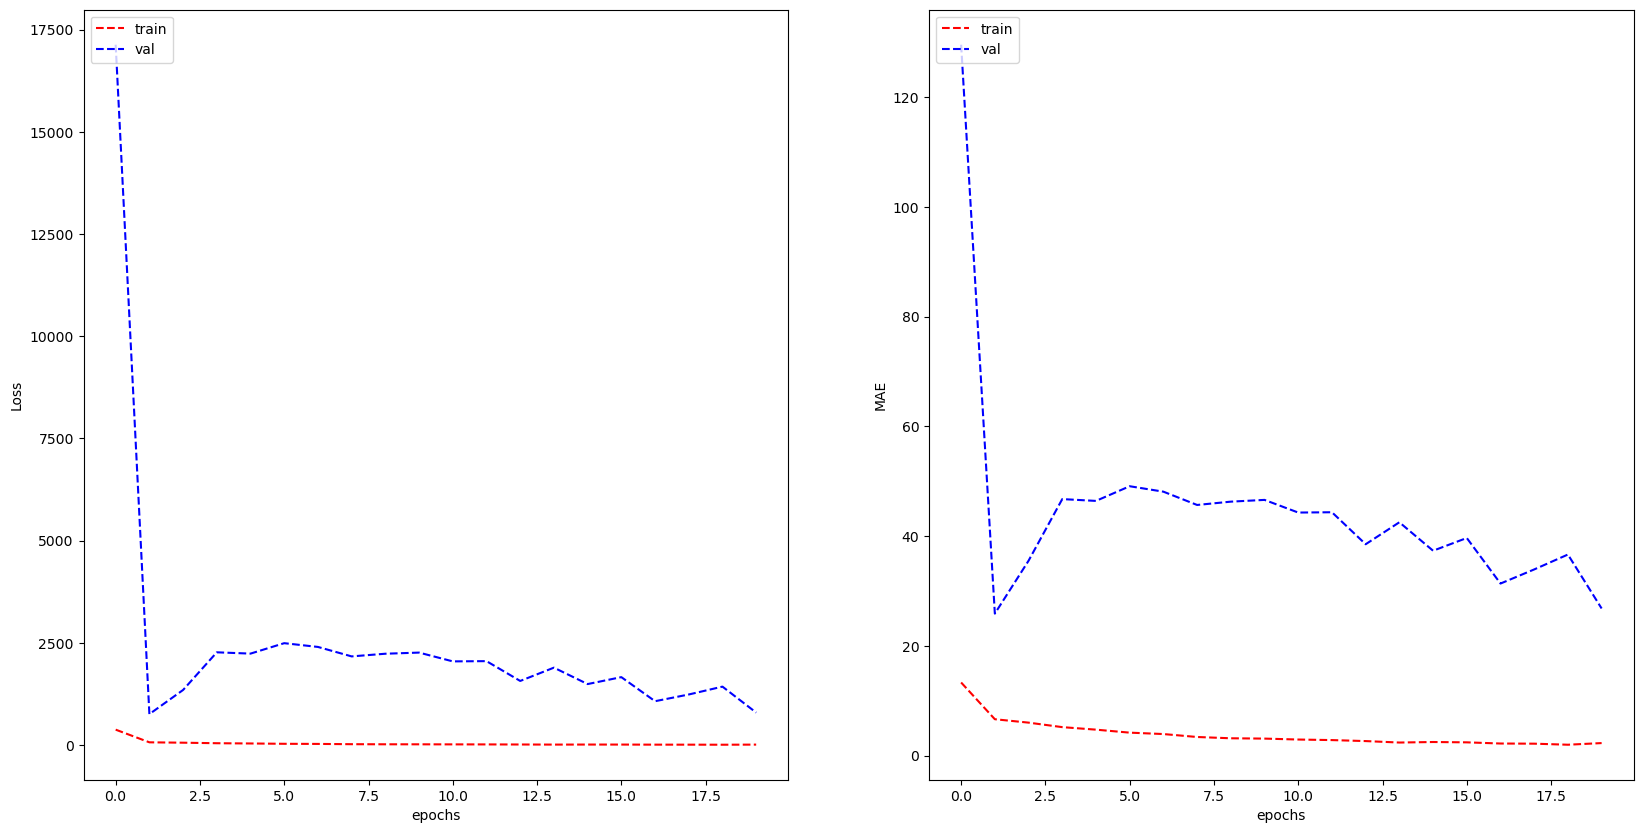

In [45]:
plot_learning_curve(
    NASNetMobile_history.history["loss"],
    NASNetMobile_history.history["val_loss"],
    NASNetMobile_history.history["mae"],
    NASNetMobile_history.history["val_mae"],
    metric_name="MAE",
)

### 2.3) Model Evaluation
**Justifications for Using MAE and MSE in Task 3 (Age Prediction)**

**Mean Absolute Error (MAE):**

- **Intuitive interpretation:** MAE measures the average absolute difference between predicted and true ages, directly indicating how many days off the predictions are on average.
- **Robustness to outliers:** MAE treats all errors linearly, so it is less sensitive to large outliers in age prediction compared to MSE.
- **Meaningful for real-world impact:** Since age prediction errors translate directly to days, MAE provides a straightforward sense of typical prediction error magnitude, which is often more interpretable for stakeholders like farmers.

**Mean Squared Error (MSE):**

- **Penalizes larger errors more:** By squaring the errors, MSE gives more weight to larger mistakes, encouraging the model to focus on minimizing substantial deviations in predicted age.
- **Mathematically convenient:** MSE is differentiable and smooth, which helps gradient-based optimization converge efficiently during training.
- **Common regression metric:** MSE is widely used in regression tasks, providing a standard benchmark to compare model performance across studies and implementations.

In [53]:
best_mobilenetv3small_epoch = np.argmin(MobileNetV3Small_history.history["val_mae"])
mobilenetv3small_val_mae = MobileNetV3Small_history.history["val_mae"][best_mobilenetv3small_epoch]
mobilenetv3small_train_mae = MobileNetV3Small_history.history["mae"][best_mobilenetv3small_epoch]

best_resnet50v2_epoch = np.argmin(ResNet50V2_history.history["val_mae"])
resnet50v2_val_mae = ResNet50V2_history.history["val_mae"][best_resnet50v2_epoch]
resnet50v2_train_mae= ResNet50V2_history.history["mae"][best_resnet50v2_epoch]

best_nasnetmobile_epoch = np.argmin(NASNetMobile_history.history["val_mae"])
nasnetmobile_val_mae= NASNetMobile_history.history["val_mae"][best_nasnetmobile_epoch]
nasnetmobile_train_mae= NASNetMobile_history.history["mae"][best_nasnetmobile_epoch]

model_results = {
    "MobileNetV3Small": ( mobilenetv3small_train_mae, mobilenetv3small_val_mae),
    "ResNet50V2": (resnet50v2_train_mae, resnet50v2_val_mae),
    "NasNetMobile": (nasnetmobile_train_mae, nasnetmobile_val_mae),
}

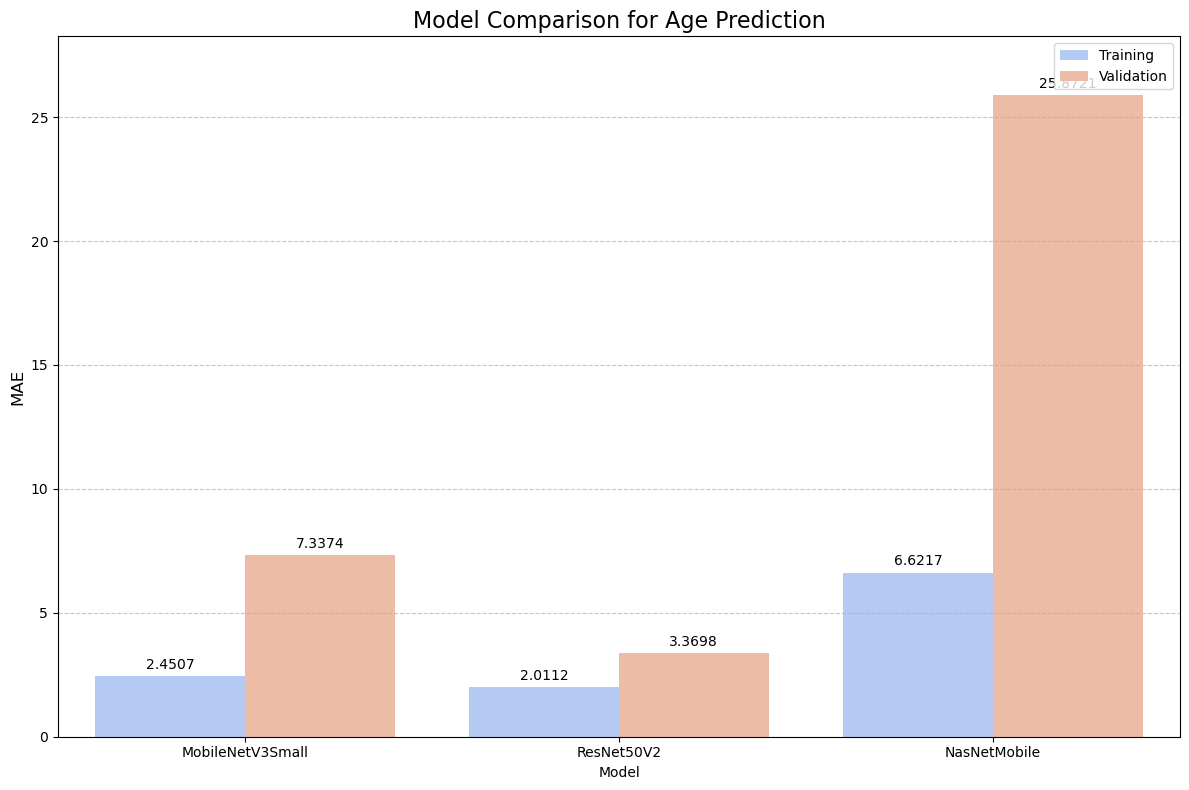

In [54]:
plot_regression_model_results(
    model_results,
    metric_name="MAE",
    title="Model Comparison for Age Prediction",
    figsize=(12, 8),
)

**Obervations:**
- NasNetMobile perform quite bad with train_mae (6.62) and the val_mae is very high (25.87) which means that the model is extremely overfitting
- MobileNetV3Small perform quite well with train_mae (2.45) but there is a gap between the train_mae with the val_mae (7.3374) which means that the model is overfitting
- ResNet50V2 is the best model with train_mae (2.01) and val_mae (3.37) which means that the model is not overfitting too much and we can apply fine-tuning to enhance the ResNet50V2 model's performance

### 2.4) Model Selection and Hyperparameter Tuning

To handle overfitting situation, we used the following techniques:
1. **Early Stopping**:
    - Monitor the validation loss and stop training when it starts to increase.
    - Set patience to 10 epochs, meaning training will stop if no improvement is seen for 10 consecutive epochs.
2. **Dropout**: 
    - Randomly drop a fraction of neurons during training to prevent co-adaptation.
    - Set dropout rate to 0.5, meaning 50% of neurons will be dropped.
3. **Batch Normalization**:
    - Normalize the output of a layer to stabilize learning and improve convergence.
    - Apply batch normalization after each convolutional layer.
4. **L2 Regularization**:
    - Add a penalty to the loss function for large weights to prevent overfitting.
    - Train the model with several values of L2 regularization (0.01, 0.001, 0.005, 0.0001) to find the best one.

Creat a subset of the dataset with 30% of the original dataset for speeding up the prcess of selecting best lamda for L2 regularization

In [67]:
# Create quantile-based bins 
train_df['age_bin'] = pd.qcut(train_df['age'], q=10, duplicates='drop')

subset_df, _ = train_test_split(
    train_df, test_size=0.7, stratify=train_df['age_bin'], random_state=42
)

subset_train_df, subset_val_df = train_test_split(
    subset_df, test_size=0.2, stratify=subset_df['age_bin'], random_state=42
)

# Drop helper column after split
for df in [train_df, subset_df, subset_train_df, subset_val_df]:
    if 'age_bin' in df.columns:
        df.drop(columns=['age_bin'], inplace=True)

train_subset_generator = train_datagen.flow_from_dataframe(
    dataframe=subset_train_df,
    x_col="image_path",
    y_col="age",
    target_size=(64, 64),
    class_mode="raw",
    batch_size=32,
    shuffle=True,
)

val_subset_generator = val_datagen.flow_from_dataframe(
    dataframe=subset_val_df,
    x_col="image_path",
    y_col="age",
    target_size=(64, 64),
    class_mode="raw",
    batch_size=32,
    shuffle=False,
)

Found 1997 validated image filenames.
Found 500 validated image filenames.


In [3]:
def build_resnet50v2_model(input_shape, l2_reg=None):
    """
    Builds a ResNet50V2 model for regression with optional L2 regularization.

    Parameters:
    - input_shape: Shape of the input images.
    - l2_reg: keras.regularizers.l2 instance or None.

    Returns:
    - model: Uncompiled ResNet50V2 model.
    """
    base_model = ResNet50V2(
        include_top=False,
        weights=None,
        input_shape=input_shape,
        pooling='avg'
    )

    x = base_model.output
    x = Dropout(0.5)(x)
    x = BatchNormalization()(x)
    x = Dense(1, activation='linear', kernel_regularizer=l2_reg)(x)

    model = Model(inputs=base_model.input, outputs=x)

    return model

In [70]:
LOAD_FROM_HISTORY = False
if LOAD_FROM_HISTORY:
    lambda_histories = load_lambda_histories()
    model_results = {}

    for model_name, history in lambda_histories.items():
        # For regression, monitor val_mae or val_loss
        best_epoch = np.argmin(history.history["val_mae"])  # or "val_loss"
        val_mae = history.history["val_mae"][best_epoch]
        train_mae = history.history["mae"][best_epoch]
        model_results[model_name] = (train_mae, val_mae)

else:
    lambda_parameters = [0.0001, 0.001, 0.005, 0.01]
    model_results = {}

    for para_l2_strength in lambda_parameters:
        print(f"\nTraining model with L2 regularization lambda = {para_l2_strength}")

        resnet50v2_model = build_resnet50v2_model(input_shape=(64,64,3), l2_reg=l2(para_l2_strength))

        resnet50v2_model.compile(
            optimizer=Adam(learning_rate=0.0001),
            loss="mse",
            metrics=["mae"],
        )

        early_stopping = EarlyStopping(
            monitor="val_mae",  # regression metric, not accuracy
            patience=15,
            restore_best_weights=True
        )

        history = resnet50v2_model.fit(
            train_subset_generator,
            validation_data=val_subset_generator,
            epochs=20,
            callbacks=[early_stopping],
            verbose=1,
        )

        # Save model and history
        model_name = f"resnet50v2_{para_l2_strength}_lambda"
        save_model_and_history(resnet50v2_model, history, model_name)

        # Find best epoch based on lowest val_mae
        best_epoch = np.argmin(history.history["val_mae"])
        val_mae = history.history["val_mae"][best_epoch]
        train_mae = history.history["mae"][best_epoch]

        model_results[model_name] = (train_mae, val_mae)

# Sort by lambda
model_results = dict(
    sorted(model_results.items(), key=lambda x: float(x[0].split("_")[1]))
)


Training model with L2 regularization lambda = 0.0001
Epoch 1/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 73s 777ms/step - loss: 4186.5557 - mae: 64.0806 - val_loss: 4325.4878 - val_mae: 65.1449
Epoch 2/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 46s 732ms/step - loss: 4115.7915 - mae: 63.6947 - val_loss: 4722.2739 - val_mae: 68.1205
Epoch 3/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 49s 778ms/step - loss: 4058.3586 - mae: 63.4045 - val_loss: 4938.3501 - val_mae: 69.6771
Epoch 4/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 60s 933ms/step - loss: 3952.7224 - mae: 62.6587 - val_loss: 4930.4585 - val_mae: 69.6035
Epoch 5/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 62s 987ms/step - loss: 3787.8975 - mae: 61.3652 - val_loss: 4159.0527 - val_mae: 63.7935
Epoch 6/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 76s 1s/step - loss: 3652.5625 - mae: 60.2556 - val_loss: 3774.9702 - val_mae: 60.7062
Epoch 7/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 56s 891ms/step - loss: 3475.4470 - mae: 58.7720 - val_loss: 3396.9585 - val_mae: 57.4926
Epoch 8/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 51s 815ms/step - loss

In this case, we can observe that the training MAE is higher than the validation MAE, which is counter-intuitive. This can happen for several reasons:

1. **Early Stages of Training**  
   Early in training, the model may perform inconsistently on training batches due to random initialization or high learning rate.  
   - The validation MAE might appear temporarily lower if the validation set is easier or more consistent.

2. **Small Validation Set or Data Distribution Differences**  
   The validation set is small or less complex than the training set, validation error can be artificially lower.  
   - Differences in data distribution or sample difficulty can cause this counter-intuitive result.

However, our purpose is to find the best lambda for L2 regularization and use that L2 `lamda` to train on full dataset, so we only focus on the smallest gap between the train and val MAE. For that reason, the best lambda is 0.005 with the smallest gap of 3.42 between the train and val MAE.

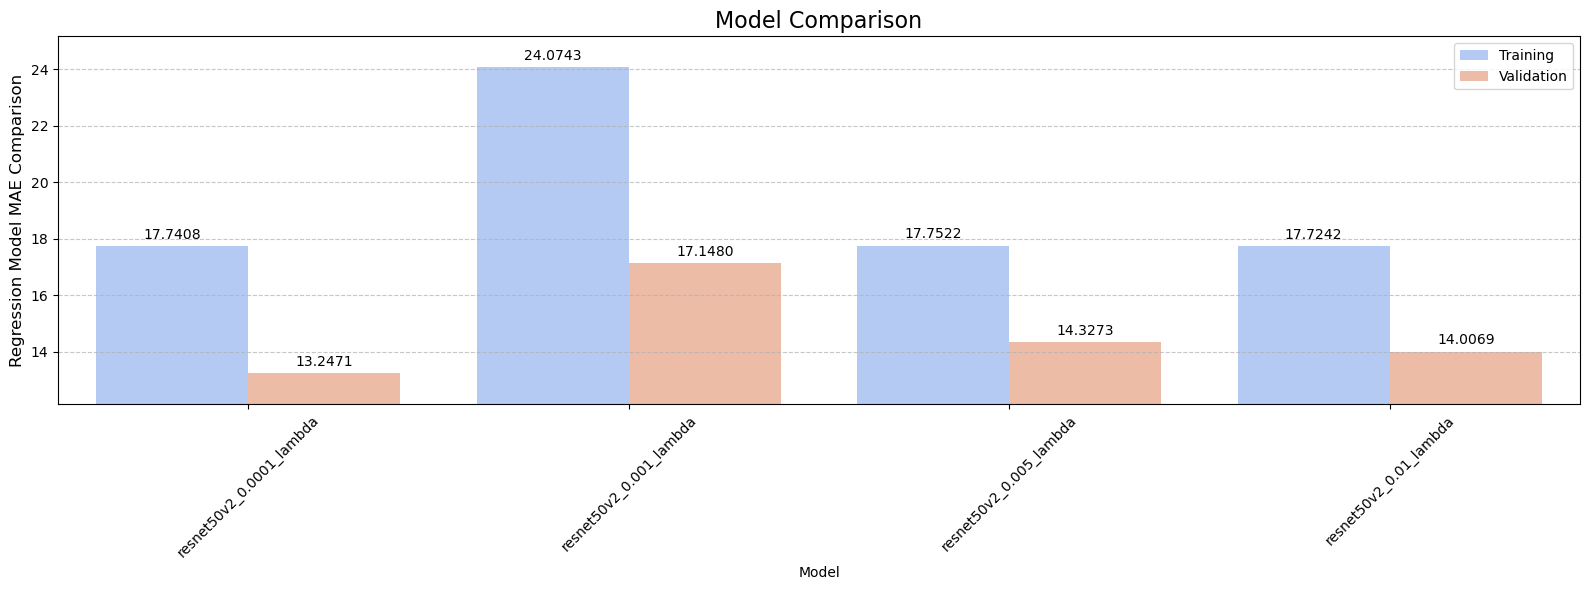

In [71]:
plot_regression_model_results(
    model_results, "Regression Model MAE Comparison", figsize=(16, 6)
)

In [21]:
train_datagen = ImageDataGenerator(rescale=1./255, data_format='channels_last')
val_datagen = ImageDataGenerator(rescale=1./255, data_format='channels_last')

train_generator_task3 = train_datagen.flow_from_dataframe(
    dataframe=train_df,
    directory="",
    x_col='image_path',
    y_col='age',
    target_size= (128,128),
    batch_size= BATCH_SIZE,
    class_mode='raw',
    seed=42,
    shuffle=True
)

val_generator_task3 = val_datagen.flow_from_dataframe(
    dataframe=val_df,
    directory="",
    x_col='image_path',
    y_col='age',
    target_size=(128, 128),
    batch_size=BATCH_SIZE,
    class_mode='raw',
    seed=42,
    shuffle=False
)

Found 8325 validated image filenames.
Found 2082 validated image filenames.


In [22]:
resnet50v2_best_model = build_resnet50v2_model(
    input_shape=(128, 128, 3), l2_reg=l2(0.005)
)
resnet50v2_best_model.compile(
    optimizer='adam',
    loss="mse",
    metrics=["mae"],
)

reduce_lr = ReduceLROnPlateau(
    monitor='val_loss', factor=0.5, patience=2, min_lr=1e-6
)

early_stopping = EarlyStopping(
    monitor='val_loss', patience=5, restore_best_weights=True
)

model_checkpoint = ModelCheckpoint(
    './models/resnet50v2_best_model.keras', monitor='val_loss', save_best_only=True)

In [23]:
# Train the best model on the full training set
resnet50v2_best_history = resnet50v2_best_model.fit(
    train_generator_task3,
    validation_data=val_generator_task3,
    epochs=30,
    callbacks=[reduce_lr, early_stopping, model_checkpoint],
    verbose=1,
)

c:\Anaconda\envs\tf219_env\lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/30
261/261 ━━━━━━━━━━━━━━━━━━━━ 719s 3s/step - loss: 2799.9644 - mae: 48.4025 - val_loss: 32246022.0000 - val_mae: 4904.4854 - learning_rate: 0.0010
Epoch 2/30
261/261 ━━━━━━━━━━━━━━━━━━━━ 570s 2s/step - loss: 111.8475 - mae: 8.5492 - val_loss: 14418.8213 - val_mae: 49.0195 - learning_rate: 0.0010
Epoch 3/30
261/261 ━━━━━━━━━━━━━━━━━━━━ 567s 2s/step - loss: 106.4644 - mae: 8.1882 - val_loss: 4444.3848 - val_mae: 52.1197 - learning_rate: 0.0010
Epoch 4/30
261/261 ━━━━━━━━━━━━━━━━━━━━ 606s 2s/step - loss: 101.7412 - mae: 8.0951 - val_loss: 82.6623 - val_mae: 7.3626 - learning_rate: 0.0010
Epoch 5/30
261/261 ━━━━━━━━━━━━━━━━━━━━ 624s 2s/step - loss: 92.4261 - mae: 7.6443 - val_loss: 76.2758 - val_mae: 7.1707 - learning_rate: 0.0010
Epoch 6/30
261/261 ━━━━━━━━━━━━━━━━━━━━ 626s 2s/step - loss: 86.1936 - mae: 7.3577 - val_loss: 65.5578 - val_mae: 6.2667 - learning_rate: 0.0010
Epoch 7/30
261/261 ━━━━━━━━━━━━━━━━━━━━ 600s 2s/step - loss: 79.1930 - mae: 6.9839 - val_loss: 94.5645 - val

In [26]:
save_model_and_history(
    resnet50v2_best_model,
    resnet50v2_best_history,
    model_name="resnet50v2_best_model",
    model_dir="models",
    history_dir="models/history",
)

Model saved to models\resnet50v2_best_model.keras
Full history saved to models/history\resnet50v2_best_model_history.pkl


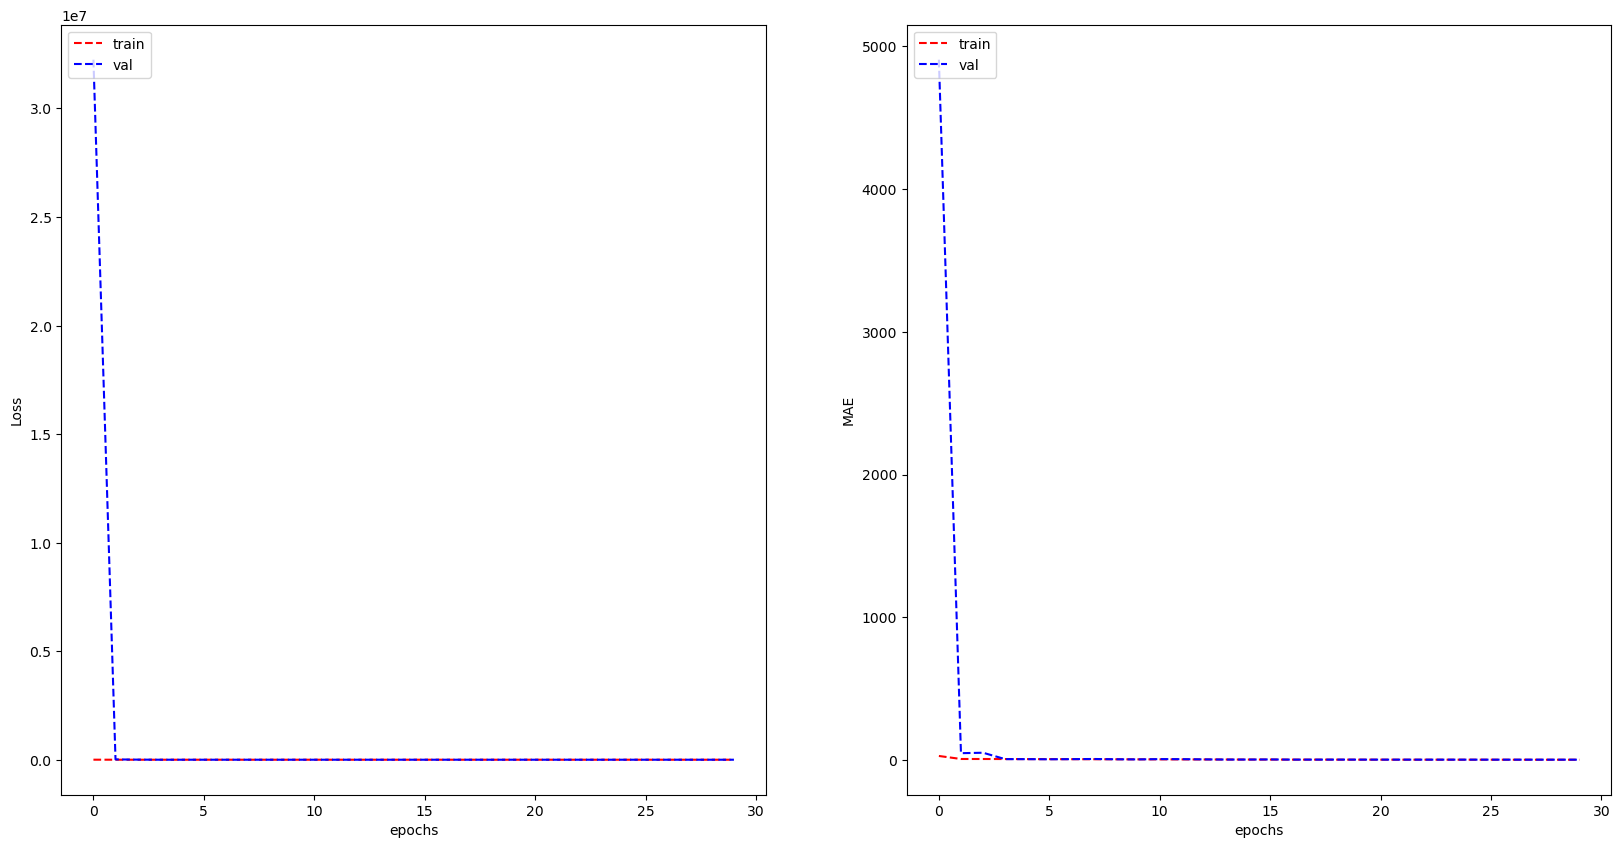

In [24]:
plot_learning_curve(
    resnet50v2_best_history.history["loss"],
    resnet50v2_best_history.history["val_loss"],
    resnet50v2_best_history.history["mae"],
    resnet50v2_best_history.history["val_mae"],
    metric_name="MAE",
)

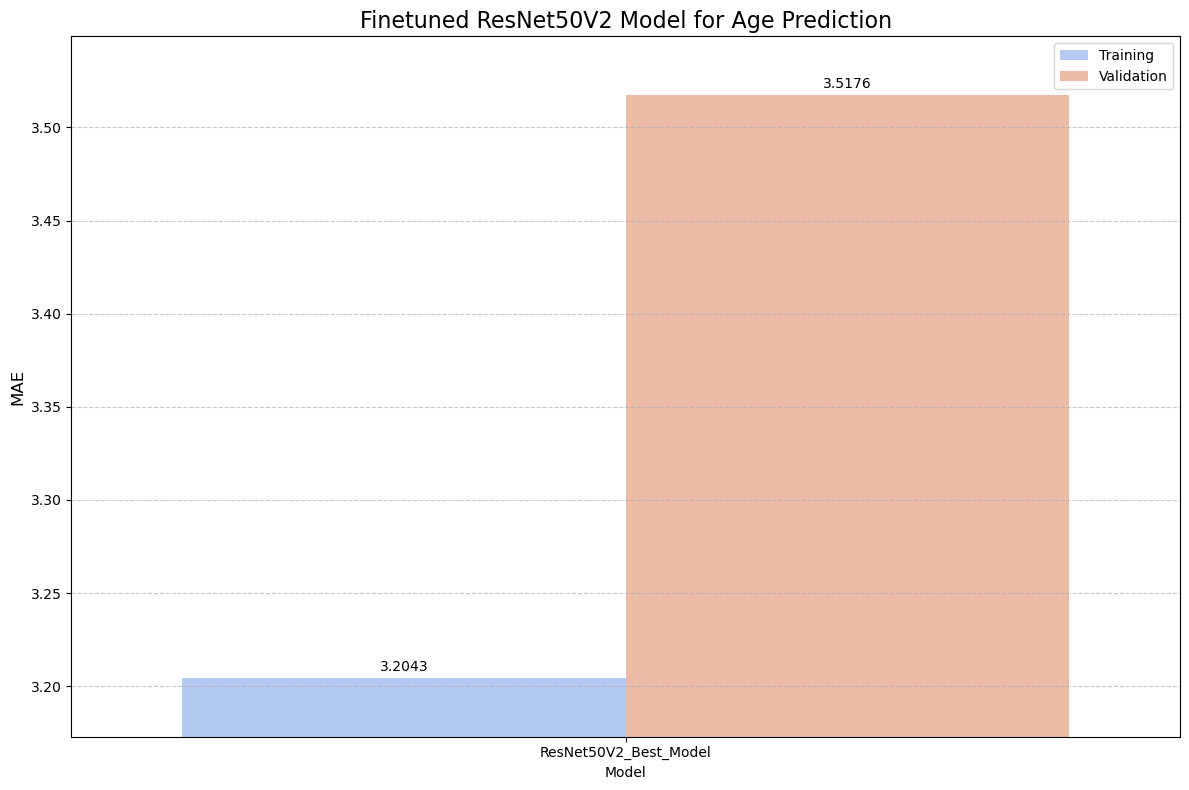

In [25]:
best_resnet50v2_best_model_epoch = np.argmin(resnet50v2_best_history.history["val_mae"])
resnet50v2_best_model_val_mae= resnet50v2_best_history.history["val_mae"][best_resnet50v2_best_model_epoch]
resnet50v2_best_model_train_mae= resnet50v2_best_history.history["mae"][best_resnet50v2_best_model_epoch]

best_model_results = {
    "ResNet50V2_Best_Model": (resnet50v2_best_model_train_mae, resnet50v2_best_model_val_mae),
}

plot_regression_model_results(
    best_model_results,
    metric_name="MAE",
    title="Finetuned ResNet50V2 Model for Age Prediction",
    figsize=(12, 8),
)